In [2]:
import numpy as np
import pandas as pd
from scipy.signal import find_peaks, butter, filtfilt
from scipy.fft import fft
from geopy.distance import geodesic

# Load data
acceleration_data = pd.read_csv('Linear Acceleration.csv')
gps_data = pd.read_csv('Location.csv')

# Filter acceleration data using a low-pass filter
def low_pass_filter(data, cutoff=2.5, fs=50.0, order=5):
    nyquist = 0.5 * fs
    normal_cutoff = cutoff / nyquist
    b, a = butter(order, normal_cutoff, btype='low', analog=False)
    y = filtfilt(b, a, data)
    return y

# Clean GPS data by removing NaN values
def clean_gps_data(gps_data):
    gps_data = gps_data.dropna(subset=['latitude', 'longitude', 'timestamp'])
    gps_data['timestamp'] = pd.to_datetime(gps_data['timestamp'])
    return gps_data

# Step 1: Calculate Step Amount from Filtered Acceleration
def calculate_steps(filtered_acceleration):
    peaks, _ = find_peaks(filtered_acceleration, height=0.5)  # Adjust height as needed
    return len(peaks)

# Step 2: Step Count from Acceleration using Fourier Analysis
def step_count_fourier(filtered_acceleration):
    N = len(filtered_acceleration)
    T = 1.0 / 50.0  # Assuming 50 Hz sampling rate
    yf = fft(filtered_acceleration)
    xf = np.fft.fftfreq(N, T)[:N//2]
    idx = np.argmax(2.0/N * np.abs(yf[:N//2]))
    dominant_frequency = xf[idx]
    return dominant_frequency

# Step 3: Average Speed using GPS Data
def calculate_average_speed(gps_data):
    speeds = []
    for i in range(1, len(gps_data)):
        coord1 = (gps_data['latitude'].iloc[i-1], gps_data['longitude'].iloc[i-1])
        coord2 = (gps_data['latitude'].iloc[i], gps_data['longitude'].iloc[i])
        distance = geodesic(coord1, coord2).meters
        time_diff = (gps_data['timestamp'].iloc[i] - gps_data['timestamp'].iloc[i-1]).total_seconds()
        speed = distance / time_diff
        speeds.append(speed)
    return np.mean(speeds)

# Step 4: Distance Traveled using GPS Data
def calculate_distance_traveled(gps_data):
    total_distance = 0.0
    for i in range(1, len(gps_data)):
        coord1 = (gps_data['latitude'].iloc[i-1], gps_data['longitude'].iloc[i-1])
        coord2 = (gps_data['latitude'].iloc[i], gps_data['longitude'].iloc[i])
        total_distance += geodesic(coord1, coord2).meters
    return total_distance

# Filter and clean data
filtered_acceleration = low_pass_filter(acceleration_data['Acceleration'])
cleaned_gps_data = clean_gps_data(gps_data)

# Perform calculations
step_amount = calculate_steps(filtered_acceleration)
step_count = step_count_fourier(filtered_acceleration)
average_speed = calculate_average_speed(cleaned_gps_data)
distance_traveled = calculate_distance_traveled(cleaned_gps_data)

print(f"Step Amount: {step_amount}")
print(f"Step Count (Fourier): {step_count}")
print(f"Average Speed: {average_speed} m/s")
print(f"Distance Traveled: {distance_traveled} meters")

KeyError: 'acceleration'

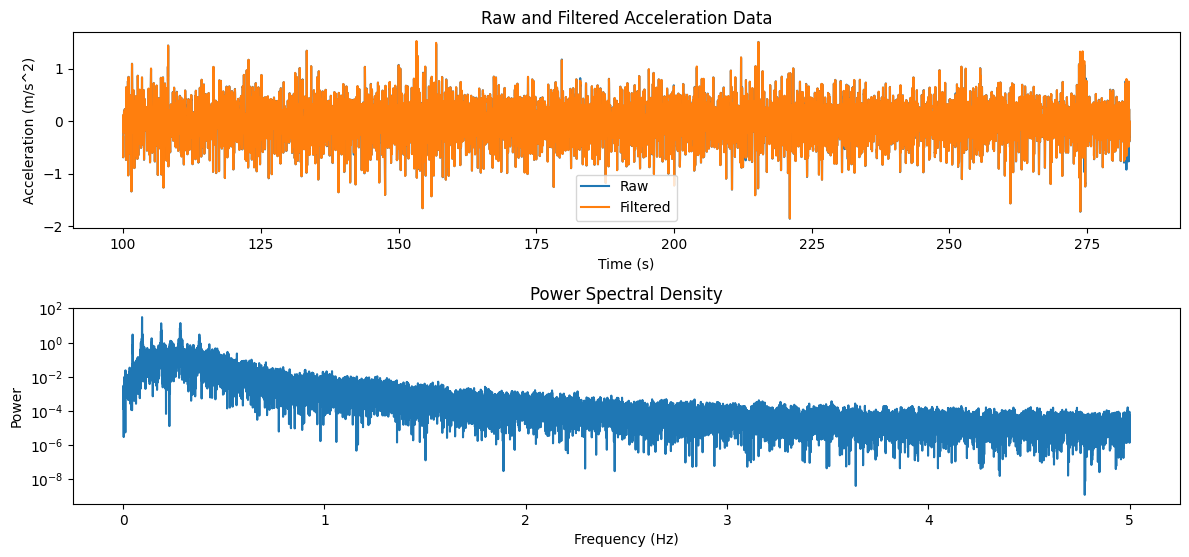

Step count (filtered): 347
Step count (Fourier): 346.0
Average speed: 1.53 m/s
Total distance: 275.28 m
Step length: 0.79 m


In [28]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import butter, filtfilt, periodogram
from geopy.distance import geodesic
import folium
from folium.plugins import HeatMap

# Load data
accel_data = pd.read_csv('Linear Acceleration.csv')
gps_data = pd.read_csv('Location.csv')

# Remove the first 100 seconds of data
accel_data = accel_data[accel_data['Time (s)'] > 100].reset_index(drop=True)
gps_data = gps_data[gps_data['Time (s)'] > 100].reset_index(drop=True)

# Preprocess acceleration data
def butter_lowpass_filter(data, cutoff, fs, order=5):
    nyquist = 0.5 * fs
    normal_cutoff = cutoff / nyquist
    b, a = butter(order, normal_cutoff, btype='low', analog=False)
    y = filtfilt(b, a, data)
    return y

# Assuming sampling rate is 50 Hz and cutoff frequency is 3 Hz
fs = 10
cutoff = 3
accel_data['filtered'] = butter_lowpass_filter(accel_data['Linear Acceleration y (m/s^2)'], cutoff, fs)

# Step count from filtered data
def count_steps(data, threshold=0.5):
    steps = ((data.shift(1) < threshold) & (data > threshold)).sum()
    return steps

step_count_filtered = count_steps(accel_data['filtered'])

# Step count from Fourier analysis
frequencies, power = periodogram(accel_data['Linear Acceleration y (m/s^2)'], fs)
dominant_frequency = frequencies[np.argmax(power[1:]) + 1]  # Exclude zero frequency
step_count_fourier = dominant_frequency * len(accel_data) / fs

# GPS data analysis
gps_data['coords'] = gps_data.apply(lambda row: (row['Latitude (°)'], row['Longitude (°)']), axis=1)
distances = [geodesic(gps_data['coords'][i], gps_data['coords'][i+1]).meters for i in range(len(gps_data)-1)]
total_distance = sum(distances)
total_time = (gps_data['Time (s)'].iloc[-1] - gps_data['Time (s)'].iloc[0])  # in seconds
average_speed = total_distance / total_time  # in meters per second

# Step length calculation
step_length = total_distance / step_count_filtered

# Visualization
plt.figure(figsize=(12, 8))

# Raw and filtered acceleration data
plt.subplot(3, 1, 1)
plt.plot(accel_data['Time (s)'], accel_data['Linear Acceleration y (m/s^2)'], label='Raw')
plt.plot(accel_data['Time (s)'], accel_data['filtered'], label='Filtered')
plt.title('Raw and Filtered Acceleration Data')
plt.xlabel('Time (s)')
plt.ylabel('Acceleration (m/s^2)')
plt.legend()

# Power spectral density
plt.subplot(3, 1, 2)
plt.semilogy(frequencies[1:], power[1:])  # Exclude zero frequency
plt.title('Power Spectral Density')
plt.xlabel('Frequency (Hz)')
plt.ylabel('Power')

# Route on map using Folium
df = gps_data[['Latitude (°)', 'Longitude (°)']].copy()
lat_mean = df['Latitude (°)'].mean()
long_mean = df['Longitude (°)'].mean()
mymap = folium.Map(location=[lat_mean, long_mean], zoom_start=14)
folium.PolyLine(df[['Latitude (°)', 'Longitude (°)']].values, color='blue', opacity=1).add_to(mymap)

# Display map in Jupyter Notebook
mymap

plt.tight_layout()
plt.show()

# Print results
print(f"Step count (filtered): {step_count_filtered}")
print(f"Step count (Fourier): {step_count_fourier}")
print(f"Average speed: {average_speed:.2f} m/s")
print(f"Total distance: {total_distance:.2f} m")
print(f"Step length: {step_length:.2f} m")

In [11]:
import numpy as np
import pandas as pd
from scipy.signal import find_peaks, butter, filtfilt
from scipy.fft import fft
from geopy.distance import geodesic
import matplotlib.pyplot as plt



# Load data
acceleration_data = pd.read_csv('Linear Acceleration.csv')
gps_data = pd.read_csv('Location.csv')

gps_data


,Time (s),Latitude (°),Longitude (°),Height (m),Velocity (m/s),Direction (°),Horizontal Accuracy (m),Vertical Accuracy (m)
0,1.023019,64.934454,25.415666,9.078086,NaN,NaN,11.631000,1.000000
1,1.448301,64.934454,25.415666,9.078086,NaN,NaN,14.606000,1.595000
2,21.945019,64.934300,25.416295,8.777966,NaN,NaN,19.951000,1.000000
3,41.882019,64.934303,25.416293,8.677968,NaN,NaN,20.090000,1.000000
4,61.969019,64.934308,25.416215,8.677970,NaN,NaN,20.042000,1.000000
5,81.990019,64.934298,25.416027,8.777958,NaN,NaN,30.405001,1.000000
6,101.957019,64.934377,25.416354,8.678034,NaN,NaN,15.465000,1.000000
7,121.962019,64.934578,25.416117,8.778204,NaN,NaN,20.830999,1.000000
8,142.006019,64.934659,25.416034,8.778272,NaN,NaN,16.957001,1.000000
9,161.991019,64.935004,25.416391,8.778578,NaN,NaN,22.909000,1.216151


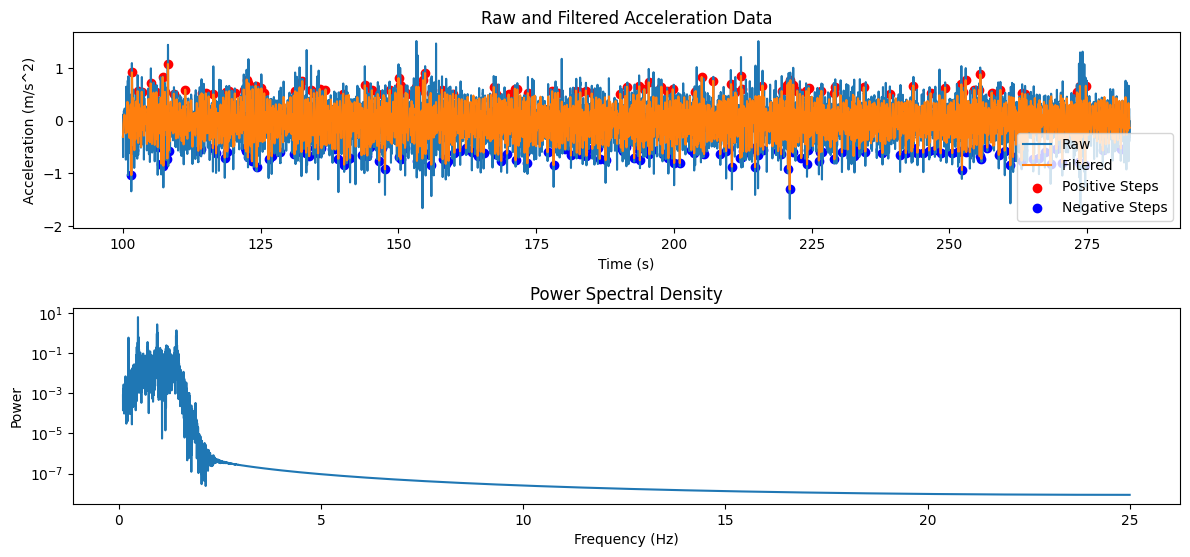

Step count (filtered): 289
Step count (Fourier): 346.0
Average speed: 1.53 m/s
Total distance: 275.28 m
Step length: 0.95 m


In [5]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import butter, filtfilt, find_peaks, periodogram
from geopy.distance import geodesic
import folium

# Load data
accel_data = pd.read_csv('Linear Acceleration.csv')
gps_data = pd.read_csv('Location.csv')

# Define the idle time to be removed
idle_time = 100  # seconds

# Remove the first 100 seconds of data
accel_data = accel_data[accel_data['Time (s)'] > idle_time].reset_index(drop=True)
gps_data = gps_data[gps_data['Time (s)'] > idle_time].reset_index(drop=True)

# Preprocess acceleration data
def butter_lowpass_filter(data, cutoff, fs, order=8):  # Increased filter order to 8
    nyquist = 0.5 * fs
    normal_cutoff = cutoff / nyquist
    b, a = butter(order, normal_cutoff, btype='low', analog=False)
    y = filtfilt(b, a, data)
    return y

# Assuming sampling rate is 50 Hz and cutoff frequency is 1.5 Hz (lowered cutoff frequency)
fs = 50
cutoff = 1.5
accel_data['filtered'] = butter_lowpass_filter(accel_data['Linear Acceleration y (m/s^2)'], cutoff, fs)

# Step count from filtered data using peak detection
positive_peaks, _ = find_peaks(accel_data['filtered'], height=0.5, distance=fs*0.5)  # Positive peaks
negative_peaks, _ = find_peaks(-accel_data['filtered'], height=0.5, distance=fs*0.5)  # Negative peaks
step_count_filtered = len(positive_peaks) + len(negative_peaks)

# Step count from Fourier analysis on filtered data
frequencies, power = periodogram(accel_data['filtered'], fs)
dominant_frequency = frequencies[np.argmax(power[1:]) + 1]  # Exclude zero frequency
step_count_fourier = dominant_frequency * len(accel_data) / fs

# GPS data analysis
gps_data['coords'] = gps_data.apply(lambda row: (row['Latitude (°)'], row['Longitude (°)']), axis=1)
distances = [geodesic(gps_data['coords'][i], gps_data['coords'][i+1]).meters for i in range(len(gps_data)-1)]
total_distance = sum(distances)
total_time = (gps_data['Time (s)'].iloc[-1] - gps_data['Time (s)'].iloc[0])  # in seconds
average_speed = total_distance / total_time  # in meters per second

# Step length calculation
if step_count_filtered > 0:
    step_length = total_distance / step_count_filtered
else:
    step_length = 0

# Visualization
plt.figure(figsize=(12, 8))

# Raw and filtered acceleration data
plt.subplot(3, 1, 1)
plt.plot(accel_data['Time (s)'], accel_data['Linear Acceleration y (m/s^2)'], label='Raw')
plt.plot(accel_data['Time (s)'], accel_data['filtered'], label='Filtered')
plt.scatter(accel_data['Time (s)'].iloc[positive_peaks], accel_data['filtered'].iloc[positive_peaks], color='red', label='Positive Steps')
plt.scatter(accel_data['Time (s)'].iloc[negative_peaks], accel_data['filtered'].iloc[negative_peaks], color='blue', label='Negative Steps')
plt.title('Raw and Filtered Acceleration Data')
plt.xlabel('Time (s)')
plt.ylabel('Acceleration (m/s^2)')
plt.legend()

# Power spectral density
plt.subplot(3, 1, 2)
plt.semilogy(frequencies[frequencies > 0.1], power[frequencies > 0.1])  # Exclude super low frequencies
plt.title('Power Spectral Density')
plt.xlabel('Frequency (Hz)')
plt.ylabel('Power')

# Route on map using Folium
df = gps_data[['Latitude (°)', 'Longitude (°)']].copy()
lat_mean = df['Latitude (°)'].mean()
long_mean = df['Longitude (°)'].mean()
mymap = folium.Map(location=[lat_mean, long_mean], zoom_start=14)
folium.PolyLine(df[['Latitude (°)', 'Longitude (°)']].values, color='blue', opacity=1).add_to(mymap)

# Display map in Jupyter Notebook
mymap

plt.tight_layout()
plt.show()

# Print results
print(f"Step count (filtered): {step_count_filtered}")
print(f"Step count (Fourier): {step_count_fourier}")
print(f"Average speed: {average_speed:.2f} m/s")
print(f"Total distance: {total_distance:.2f} m")
print(f"Step length: {step_length:.2f} m")

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
path = 'Location.csv'


df = pd.read_csv(path)
df.head()

,Time (s),Latitude (°),Longitude (°),Height (m),Velocity (m/s),Direction (°),Horizontal Accuracy (m),Vertical Accuracy (m)
0,1.023019,64.934454,25.415666,9.078086,NaN,NaN,11.631,1.000
1,1.448301,64.934454,25.415666,9.078086,NaN,NaN,14.606,1.595
2,21.945019,64.934300,25.416295,8.777966,NaN,NaN,19.951,1.000
3,41.882019,64.934303,25.416293,8.677968,NaN,NaN,20.090,1.000
4,61.969019,64.934308,25.416215,8.677970,NaN,NaN,20.042,1.000
